In [76]:
%matplotlib inline
import collections
import re
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
from d2l import torch as d2l


In [77]:
focue_CPU = False
#focue_CPU = True

def get_device():
    curr_dev = torch.device("cpu")
    if focue_CPU == True:
        curr_dev = torch.device("cpu")
    else:
        curr_dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return curr_dev

curr_device = get_device()
print("current device : ", curr_device)
#currr_device = torch.device("cpu")

current device :  cuda:0


In [78]:
curr_device

device(type='cuda', index=0)

In [79]:
d2l.try_gpu()

device(type='cuda', index=0)

读取数据集

In [80]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():

    with open(d2l.download("time_machine"), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'文本总行数：{len(lines)}')
print(lines[0])
print(lines[-1])

文本总行数：3221
the time machine by h g wells
of man


In [81]:
def tokenize(lines, token ='word'):
    if token == 'word':
        return [ line.split() for line in lines ]
    elif token == 'char':
        return [ list(line) for line in lines ]
    else:
        print('错误：未知词元类型：' + token)
        return None
    
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [82]:
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [83]:
counter = count_corpus(tokens)
token_freqs = sorted(counter.items(), key = lambda x:x[1], reverse = True)
token_freqs

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158),
 ('this', 152),
 ('you', 137),
 ('on', 137),
 ('then', 134),
 ('his', 129),
 ('there', 127),
 ('he', 123),
 ('have', 122),
 ('they', 122),
 ('from', 122),
 ('one', 120),
 ('all', 118),
 ('not', 114),
 ('into', 114),
 ('upon', 113),
 ('little', 113),
 ('so', 112),
 ('is', 106),
 ('came', 105),
 ('by', 103),
 ('some', 94),
 ('be', 93),
 ('no', 92),
 ('could', 92),
 ('their', 91),
 ('said', 89),
 ('saw', 88),
 ('down', 87),
 ('them', 86),
 ('machine', 85),
 ('which', 85),
 ('very', 85),
 ('or', 84),
 ('an', 84),
 ('we', 82),
 ('now', 79),
 ('what', 77),
 ('been', 75),
 ('these', 74),
 ('like', 74),
 ('her', 74),
 ('out', 73),
 ('seemed', 72),
 ('up', 71),
 ('man', 70),
 ('about', 70),
 ('s', 70),
 

In [84]:
class Vocab:  # 文本词表
    def __init__(self, tokens=None, min_freq=0, reversed_tokens = None):
        if tokens is None:
            tokens = []
        if reversed_tokens is None:
            reversed_tokens = []

        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key = lambda x:x[1], reverse = True)

        self.idx_to_token = ['<unk>'] + reversed_tokens
        self.token_to_idx = {token:idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) -1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list,tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices,(list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    

In [85]:
vocab = Vocab(tokens)
#print(list(vocab.token_to_idx.items())[:10])
#print(vocab.token_to_idx.items())
len(vocab)

4580

In [86]:
for i in [0,10,15]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]
文本: ['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully']
索引: [2196, 116, 289, 1424, 78, 76, 2197, 2198]


整合所有功能

In [87]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(170580, 28)

自然语文统计

In [88]:
vocab.token_freqs[:10]

[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674)]

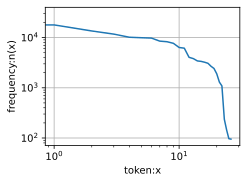

In [89]:
freqs = [ freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel="token:x", ylabel='frequency:n(x)', xscale='log', yscale='log')

In [90]:
corpus_word = [ token for line in tokens for token in line]
corpus_word[:10]

['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']

In [91]:
bigram_tokens = [pair for pair in zip(corpus_word[:-1], corpus_word[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

二元语法组合

In [92]:
bigram_tokens = [pair for pair in zip(corpus_word[:-1],corpus_word[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

三元语法组合

In [93]:
trigram_tokens =[triple for triple in zip(corpus_word[:],corpus_word[1:],corpus_word[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

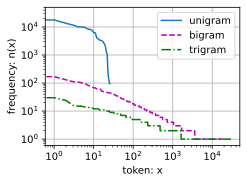

In [94]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

##### 读取长序列数据

随机采样

In [95]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们[**生成一个从$0$到$34$的序列**]。
假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。


In [96]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[11, 12, 13, 14, 15],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[21, 22, 23, 24, 25],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [27, 28, 29, 30, 31]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [17, 18, 19, 20, 21]])


In [97]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [98]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


现在，我们[**将上面的两个采样函数包装到一个类中**]，
以便稍后可以将其用作数据迭代器。


In [99]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [100]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [101]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# 循环神经网络的简单实现

初始化模型参数

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。
事实上，我们还没有讨论多层循环神经网络的意义（这将在 :numref:`sec_deep_rnn`中介绍）。
现在仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。

In [102]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [103]:
state = torch.zeros((1, batch_size,num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [104]:
X = torch.rand(size = (num_steps, batch_size, len(vocab)))
Y, new_state =  rnn_layer(X, state)
Y.shape, new_state.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

定义网络模型

In [105]:
class RNNModel(nn.Module):
    
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size

        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)

        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

训练与预测

In [106]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))

    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])

    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    return ''.join([vocab.idx_to_token[i] for i in outputs])



梯度裁剪

In [107]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

训练

In [108]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [109]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [110]:

net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(curr_device)
d2l.predict_ch8('time traveller', 10, net, vocab, curr_device)


"\nnet = RNNModel(rnn_layer, vocab_size=len(vocab))\nnet = net.to(curr_device)\nd2l.predict_ch8('time traveller', 10, net, vocab, curr_device)\n"

In [111]:
# RNN 数据顺序训练
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, curr_device)


'\nnum_epochs, lr = 500, 1\ntrain_ch8(net, train_iter, vocab, lr, num_epochs, curr_device)\n'

使用随机抽样

困惑度 1.3, 717810.4 词元/秒 cuda:0
time traveller after the pauserequired for the proper assimilati
travellerit s against reason said filbywhat saidenient to s


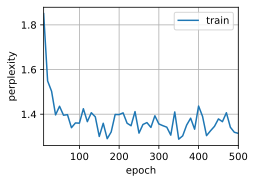

In [114]:
# RNN 数据随机训练
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(curr_device)

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, curr_device,
          use_random_iter=True)


困惑度 1.4, 437445.7 词元/秒 cuda:0
time travellerit s against reason said filbywhat this is so exte
travellerit s against reason said filbywhat this is so exte


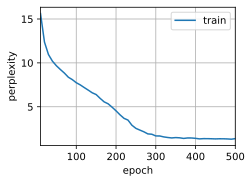

In [115]:
num_inputs = len(vocab)
gru_layer = nn.GRU(num_inputs, num_hiddens)
net = RNNModel(gru_layer, len(vocab))
net = net.to(curr_device)
train_ch8(net, train_iter, vocab, lr, num_epochs, curr_device,
          use_random_iter=True)